# Kurvy

Welcome! The purpose of this demo is to demonstrate the basic functionality of `kurvy` as applied to the most fundamental use case: approximating trigonometric curves.

## Step 1: Setup

In [1]:
# import numpy and set up rng
import numpy as np
rng = np.random.default_rng()

In [2]:
# import kurvy!
import kurvy

In [3]:
# config
scale_min = 0
scale_max = 1
train_test_split = (85,15)

## Step 2: Data Prep

Here we make use of the `kurvy` to generate some random data.

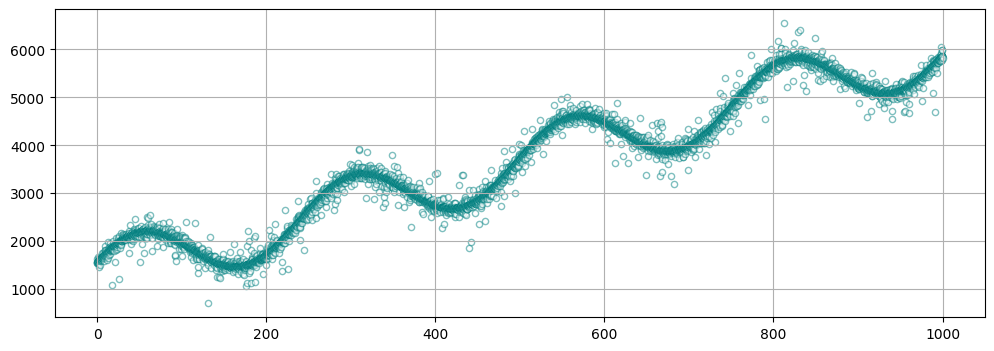

Amplitude: 640.529
Period: 256.216
Phase Shift: 177.125
Vertical Offset: 1313.754
Linear Trend: 4.704


In [4]:
real_params, X_raw, Y_raw = kurvy.trig.make_trig_data((0,1000),10000,fuzz=3,seed=104)
kurvy.plots.simple_plot(X_raw, Y_raw)
print(f"Amplitude: {np.round(real_params[0],3)}")
print(f"Period: {np.round(real_params[1],3)}")
print(f"Phase Shift: {np.round(real_params[2],3)}")
print(f"Vertical Offset: {np.round(real_params[3],3)}")
print(f"Linear Trend: {np.round(real_params[4],3)}")

We then use the `kurvy.utils` module to do some preprocessing.

In [5]:
# scale X data
X_raw_min = np.min(X_raw)
X_raw_max = np.max(X_raw)
X = kurvy.utils.min_max_scale(X_raw,scale_min,scale_max,X_raw_min,X_raw_max)
# scale Y data
Y_raw_min = np.min(Y_raw)
Y_raw_max = np.max(Y_raw)
Y = kurvy.utils.min_max_scale(Y_raw,scale_min,scale_max,Y_raw_min,Y_raw_max)
# combine X and Y data
XY = np.dstack((X,Y))[0]

In [6]:
# shuffle data
shuffle_idxs = rng.choice(XY.shape[0],XY.shape[0],replace=False)
XY = XY[shuffle_idxs]

In [7]:
# split data
splits = kurvy.utils.split_n(XY.shape[0],train_test_split)
XY_train = XY[:splits[0]]
X_train = XY_train[:,0]
Y_train = XY_train[:,1]
XY_test = XY[splits[0]:]

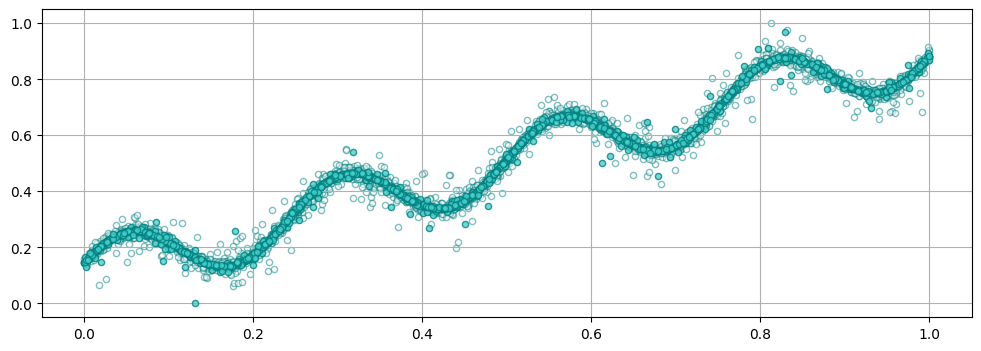

In [8]:
kurvy.plots.simple_plot(X_train,Y_train,test_data=XY_test)

## Step 3: Build a `TrigModel`

In [9]:
# instantiate the model and initialize the parameters using smart init
tm = kurvy.trig.TrigModel(smart_init=True)

How well does it approximate the data off the shelf?

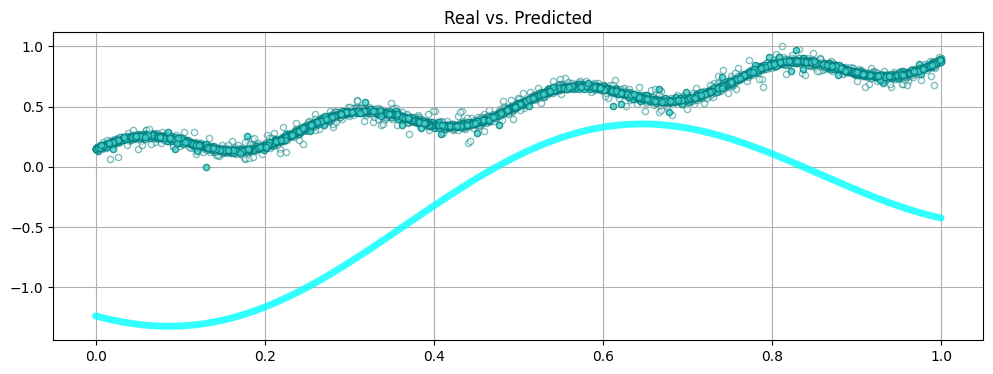

In [10]:
kurvy.plots.pred_plot(tm,X_train,Y_train,test_data=XY_test)

Terrible. Time for training!

## Step 4: Train the Model!

Initial Loss: 0.0007880449638755256


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 70.21it/s]


Final Loss: 0.00032401483414728897


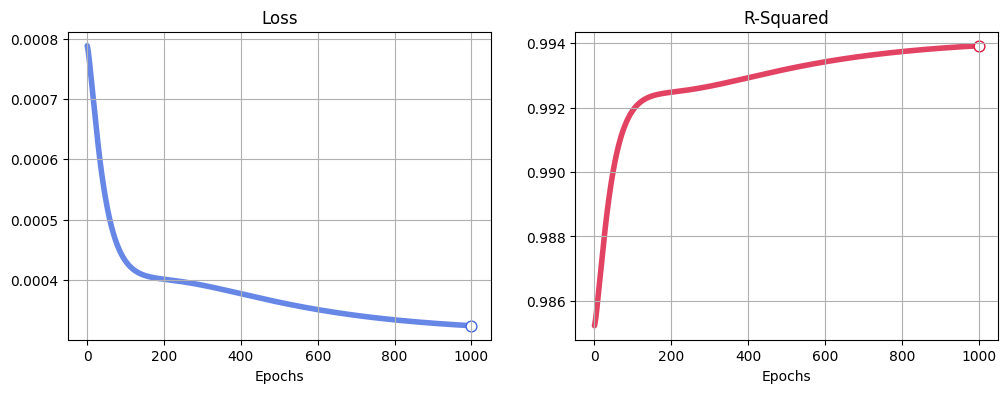

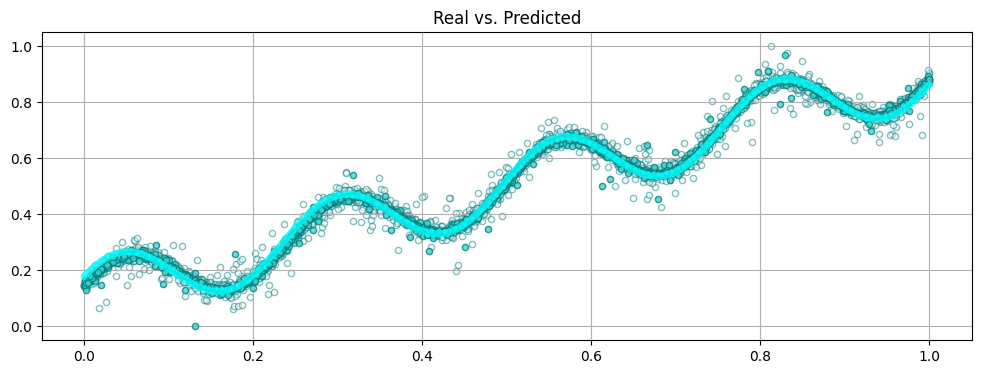

In [11]:
# train
tm.fit(
    X_train,
    Y_train,
    epochs=1000,
    learning_rate=0.001,
    momentum=0.9,
    lambda_2={"a":-0.9},
    save_best=True,
    window_size=200
)
# plot training history
kurvy.plots.plot_training(tm,"both")
# plot results
kurvy.plots.pred_plot(tm,X_train,Y_train,test_data=XY_test)

Pretty good! We can also look at how the parameters evolved throughout the training run...

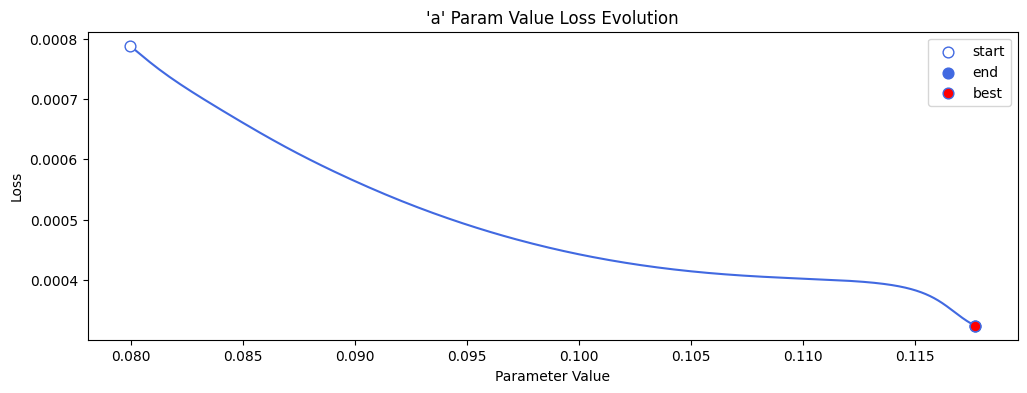

In [12]:
kurvy.plots.loss_vis(tm,"a",markers=False)

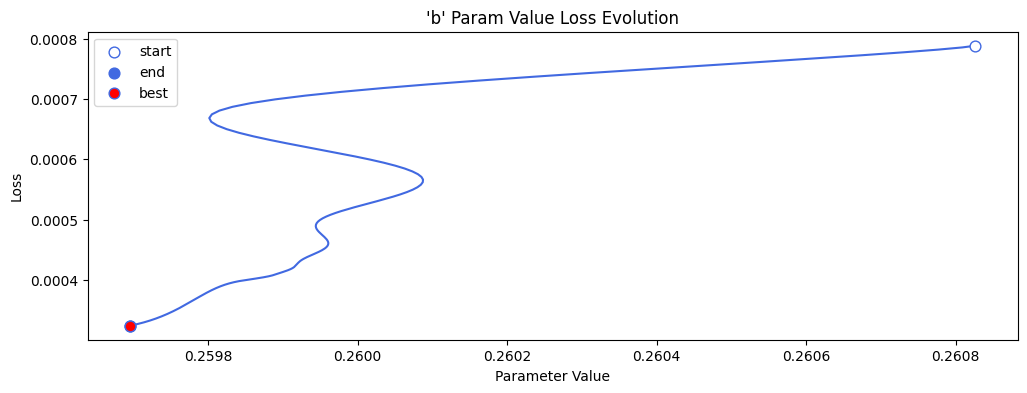

In [13]:
kurvy.plots.loss_vis(tm,"b",markers=False)

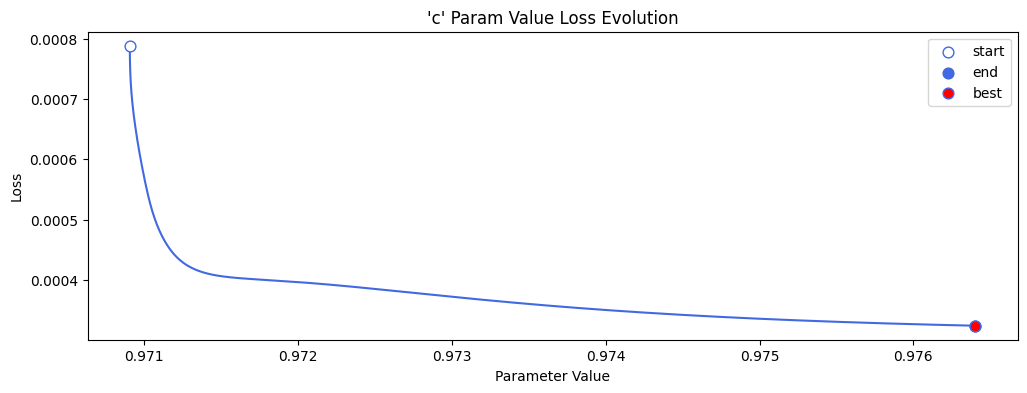

In [14]:
kurvy.plots.loss_vis(tm,"c",markers=False)

## Step 5: Scale Up and Extract the Parameters

In [15]:
# get final param values
pred_params = [tm.params[k]["value"] for k in tm.params.keys()]
# scale param values back to raw scale
a_scaled, b_scaled, c_scaled, d_scaled, e_scaled = kurvy.utils.scale_up_params(
    pred_params,
    X_raw_min,
    X_raw_max,
    Y_raw_min,
    Y_raw_max
)

In [16]:
# compare with real (generated) params
a_real, b_real, c_real, d_real, e_real = real_params
for param in [
    ("a",a_real,a_scaled),
    ("b",b_real,b_scaled),
    ("c",c_real,c_scaled),
    ("d",d_real,d_scaled),
    ("e",e_real,e_scaled),
]:
    p_real = np.round(param[1],3)
    p_scaled = np.round(param[2],3)
    dif = np.round(p_real - p_scaled,3)
    dif_pct = np.round(dif/p_real*100,2)
    
    print(f"{param[0]}\treal: {p_real}\tpred: {p_scaled}")  

a	real: 640.529	pred: 686.919
b	real: 256.216	pred: 259.695
c	real: 177.125	pred: 0.976
d	real: 1313.754	pred: 1360.643
e	real: 4.704	pred: 4.619


## And that's that!